<a href="https://colab.research.google.com/github/aiexplorations/RagaExperiments/blob/master/Ragaflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RagaFlow: Classifying Carnatic Music Ragas using Deep Neural Networks

Prepared by: Rajesh Sampathkumar (@aiexplorations)


Carnatic music is a form of Indian music, specifically from South India. It features complex patterns of scales starting from the 72 cardinal "parent" scales, to the many hundreds of derived "janya" scales, all of which are liberally used in musical compositions in and of themselves, or in combinations within the same composition. These scales are called ragas, and very often, a raga isn't just a scale, but a complex combination of scales, how to use the notes on the scale, what kinds of transition notes between scales can be played, and so on.

In this notebook, I intend to explore how deep learning techniques, combined with some audio signal processing techniques, can help us identify these ragas. 

The data we use here comes from Sangeethapriya.org, so I'd like to thank them for the data they've made available for listeners. Essentially, clips of tracks by eminent artists (hosted on Sangeethapriya) were taken and processed into short, 5 second segments.

Some quick notes:

1. In Carnatic music, compositions are generally rendered in a specific ragam
2. Practitioners of this form of music may render the raga at any starting pitch - generally a lot of the voices hover around the C, C# and D notes 
3. Violin accompaniment is common in this form of music - specifically, there is a drone accompaniment to the voice which is considered the leading melody in the music.
4. There is no concept of harmony as such in Carnatic music. There is a concept of vivadam (which could be roughly translated to dissonance). However, this is a characteristic of a scale itself, and not a specific performance.
5. Long stretches of a Carnatic music concert may be given up to just the percussion instruments. For example, a mridangam (a pitched drum) or a ghatam (a musical instrument very similar to a pot) are used extensively in Carnatic music concerts.
6. Generally, rhythm complexity in Carnatic music is high. There are incredible and complex, almost-fractal patterns of beats used in some of the complex songs.Rhythm in Carnatic music is generally called *talam* - we won't dwell on it in this analysis, since we're concerned with the melody - mainly determined by the ragam (raga).


These short tracks are then processed as input data, and machine learning models are built on top of this data.

Some notes of value to those going through this code:

1. Extensive signal analysis of the audio of the songs has not been done. I've just left in the typical noises, clicks, pops, and other kinds of variations in the data that you generally see - mainly because we humans can recognize ragas despite this, and I was just curious about what the model could learn.
2. Accounting for silences, mridangam (a kind of Indian pitched drum used in Carnatic music), violin drones or tanpura drones (which generally are used to accompany an artist
3. No specific differentiation between vocal and instrumental tracks has been made for the purpose of this analysis. The dataset contains both vocal and instrumental tracks - and perhaps this is for the better (I don't know for sure).
4. I've not done additional processing on the sound data apart from sampling in the data at different rates (here, I've used 12 kHz. Perhaps it is possible to use a different sampling rate to solve this problem too.
5. I experimented with a bunch of different models, and LSTMs are notoriously difficult to stabilize when you have smaller amounts of data. They do get better as you increase data volumes and tread carefully on regularization, dropout and such randomization hyperparameters. This is something I'm still exploring.



In [ ]:
  # PyDub is a nice library for audio processing, which includes the AudioSegment class.
  # AudioSegment is used to read and segment different music files (with potentially different encodings, rates, etc) and bring them in as lists
  # These lists are then converted to numpy arrays that are then used to prepare the data for training.
  
  !pip install pydub

In [ ]:
# Here we bring in the data from a Google Drive directory, using the glob package, and the google package - 
# The 'drive' class within the colab module allows us to mount folders and make the files available within Jupyter

import glob

# Importing drive method from colab for accessing google drive
from google.colab import drive

drive.mount('/content/drive')


data_files = glob.glob("/content/drive/My Drive/AIExplorations/carnatic_ragas_data/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
! ls '/content/drive/My Drive/AIExplorations/carnatic_ragas_data/new_processed_data/'

bhairavi  kalyani  kambhoji  kharaharapriya  shankarabharanam  thodi  varali


# The Seven Main Ragas

Though Carnatic music is known to have hundreds of distinct ragas, each with a unique sound (or "colour" as ragas are described to be analogous with different colours ... which kind of makes sense from a signal processing perspective), the most commonly performed ragas, also called the "main" ragas of Carnatic music are the following:

1. Shankarabharanam - often associated with the major scale of Western Classical music
2. Kalyani - Similar to Shankarabharanam notes-wise, just one note apart technically, but that one note makes a huge difference to the sound and feel of this raga
3. Kambhoji - an uplifting, asymmetrical ragam with different sets of notes during the ascending and descending phases of the raga
4. Thodi - An austere and grim-sounding raga with a deeply Indian vibe.
5. Varali - A variation on the Thodi raga, subtle, austere and grim
6. Bhairavi - An asymmetric raga that is closer to the Dorian or minor scales of Western music but again, uniquely Indian in flavour
7. Kharaharapriya - the Indian counterpart of the Greek Dorian mode (with extensive character of its own)

I'm not a musician outside of some guitar and although a Carnatic music aficionado, I wouldn't be qualified to write in depth about these ragas. However, I love the music and this problem of being able to understand musical notes through deep learning.

The data for each of these ragas is stored in a separate folder named for the raga.


In [ ]:
# Running a shell command to check the folders available with raga names associated with them - these are the seven "main" ragas of Carnatic music.

!ls "/content/drive/My Drive/AIExplorations/carnatic_ragas_data/new_processed_data"

bhairavi  kalyani  kambhoji  kharaharapriya  shankarabharanam  thodi  varali


In [ ]:
import numpy as np
from pydub import AudioSegment
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import pandas as pd

In [ ]:
basepath = "/content/drive/My Drive/AIExplorations/carnatic_ragas_data/new_processed_data"
ragas = []
for entry in os.listdir(basepath):
    if os.path.isdir(os.path.join(basepath, entry)):
        print(entry)
        ragas.append(entry)


kharaharapriya
varali
kalyani
bhairavi
shankarabharanam
kambhoji
thodi


# Extracting and Preparing the Data

We've brought in the data from Drive into this notebook, and now we bring it into a Numpy array to enable further processing and machine learning.

Below, I've used the native Python functions from the `os` library to read in these MP3s, and then process them with the AudioSegment() function from PyDub.

Note that I've used a lower sampling rate, and that this is 1-channel audio data.

I have also used the `pad_sequences()` function from Keras' preprocessing APIs, to build up zero-padded sequences from the music. 

Since each file is a 5 second long clip, the NUMFILES and SNIPPETSIZE variables control how many files are read, and what size of segment is taken from the array that has been brought into the runtime as an array.

*NOTE*: This step takes significant amounts of time, depending on how many files you're bringing in, and the snippet size. If you just want to run the model first, tweak those numbers to small values so that you can see faster performance. I used the GPU runtime on Colab, and it was slow even then (assuming it actually used the GPU for this process).

In [ ]:
dataset = {}
NUMFILES = 200
SNIPPETSIZE = 300000
for raga in ragas:
    #sequence list in which to store all the sequences from each file
    sequence_list = []
    files = os.listdir(os.path.join(basepath, raga))
    print("Processing files for raga ",raga, "...")
    for file in files[0:NUMFILES]: 
        filename = os.path.join(basepath, raga, file)
        sound = AudioSegment.from_file(filename, sample_rate_Hz=12000, sample_width = 1, channels = 1, format = 'mp3')
        sequence_list.append(sound.get_array_of_samples()[0:SNIPPETSIZE])
    padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence_list)
    dataset[raga] = padded_sequence

Processing files for raga  kharaharapriya ...
Processing files for raga  varali ...
Processing files for raga  kalyani ...
Processing files for raga  bhairavi ...
Processing files for raga  shankarabharanam ...
Processing files for raga  kambhoji ...
Processing files for raga  thodi ...


In [ ]:
n_records = len(dataset)*NUMFILES # We compute the number of records in the overall (training + test) data 
raga_dict = {value: idx for idx, value in enumerate(ragas)} # Construct a dictionary with unique values assigned to each raga name

In [ ]:
raga_dict

{'bhairavi': 3,
 'kalyani': 2,
 'kambhoji': 5,
 'kharaharapriya': 0,
 'shankarabharanam': 4,
 'thodi': 6,
 'varali': 1}

# Training Data and Labels as a Numpy Array

We pad each row of the `dataset` dictionary (which contains key-value pairs of ragas and the associated raga snippet to arrive at consistent lengths for each of the snippets, and then prepare a data set which can be used for training and testing.

We also prepare the labels for each snippet - we're building a supervised classification model here, and so the labels are essential.

Note that we reshaped the `prepared_data` with the target shape (`n_records`, `SNIPPETSIZE`, 1) - this is essential because we're going to be feeding the data into our model in batches, and the shape of the model should allow this.

In [ ]:
prepared_data = []
prepared_labels = []

for key, value in dataset.items():
  for row in value:
    if len(row) < SNIPPETSIZE:
      t = SNIPPETSIZE - len(row)
      row = np.pad(row, (0,t), "constant") #padding logic to solve the problem of different sequence lengths
    prepared_data.append(row)
    prepared_labels.append(raga_dict[key])
prepared_data = np.vstack(prepared_data)
prepared_labels = np.stack(prepared_labels)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(prepared_data)

StandardScaler(copy=True, with_mean=True, with_std=True)

A quick check reveals the shapes of the `prepared_data` and `prepared_labels`. 

1. We see that there are many examples of data, from which we can build training and testing sets. 

2. Each of these examples is an audio snippet that is a certain number of timesteps long (a timestep in this case represents a fraction of a second from the 5 second clip). 

3. There is one label for each of the audio snippets.

In [ ]:
prepared_data.shape, prepared_labels.shape

((1400, 300000), (1400,))

The `prepared_labels` ought to contain one code for each of the 7 ragas in the list of input ragas we saw earlier.

In [ ]:
set(prepared_labels)

{0, 1, 2, 3, 4, 5, 6}

We build up a couple of variables to parametrize the model. The sequence size (as we saw above) and the number of inputs (records) are shown here.

In [ ]:
seq_size, n_input = prepared_data[0].shape[0], len(prepared_data)

# Optional : One Hot Encoding

While I have not actually used the result from this step, it can be valuable if you're training your model differently. Specifically, if you're using a Sparse matrix to represent the labels (one-hot form) you will have to specify 'sparse_categorical_crossentropy' as your loss function.

In [ ]:
from keras.utils.np_utils import to_categorical   

categorical_labels = to_categorical(prepared_labels, num_classes=len(set(prepared_labels)))

Using TensorFlow backend.


# Key Keras Imports

Since we're building a `Sequential()` model in Keras that is a hybrid deep neural network, we require the LSTM, TimeDistributed, Conv1D layers. We also import other common layers, losses and helper functions for regularization and preprocessing.

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Flatten, TimeDistributed, Conv1D, MaxPooling1D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l1_l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

It is customary to use holding cross validation for building models for such problems and I've done the same here. Equally, we could approach this using k-fold cross validation, with any number of folds of your choice. 

Here I've just set aside 30% of the data for testing purposes. Note that I've converted the labels list to a Numpy array, for ease of feeding into the model.

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(prepared_data, np.array(prepared_labels), test_size = 0.3 )

In [ ]:
train_x_sc = scaler.transform(train_x).reshape(train_x.shape[0], SNIPPETSIZE, 1)
test_x_sc = scaler.transform(test_x).reshape(test_x.shape[0], SNIPPETSIZE, 1)

A quick check reveals the shapes of the prepared training and test data, before and after scaling and processing.

In [ ]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((980, 300000), (980,), (420, 300000), (420,))

In [ ]:
train_x_sc.shape, test_x_sc.shape

((980, 300000, 1), (420, 300000, 1))

# Common Hyperparameters

1. We're setting common hyperparameters in this section to ensure we can control the training process closely. For purposes of simplicity, we control hidden layer count and number of LSTM units from here. Equally, we could custom-build our models by feeding these numbers in where needed.

2. Note that ConvNet filter size and other parameters are controlled directly from the model and are not parametrized here.

3. We also specify learning rates, dropout and learning rate decay here. Potentially, we could control these elements if we use a custom Adam() optimizer.

In [ ]:
batchsize = 16
epochs = 50
n_units = 32
n_hidden = 32
lr = 1e-3
decay = 0.1 * lr
dropout_pc = 0.05
l1, l2 = 0.01, 0.1
n_classes = len(set(train_y)) # We set the number of classes in the network based on the classes present in the training data.

Observe that we can add multiple ragas to these folders in future and have the model build here as per parametrization above.

In [ ]:
model = Sequential([
    TimeDistributed(Conv1D(filters = 200, kernel_size = 20, padding = 'same', activation = 'relu', strides=8), 
                    batch_input_shape = (None, 1, seq_size, 1) ),
    TimeDistributed(MaxPooling1D(pool_size=100)),
    TimeDistributed(Conv1D(filters = 100, kernel_size = 10, padding = 'valid', activation = 'relu', strides=4)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling1D(pool_size=50)),
    TimeDistributed(Flatten()),
    LSTM(units = 128, activation = "relu", kernel_regularizer = l1_l2(l1, l2), 
         input_shape = (seq_size, 1), return_sequences = True),
    Dense(512, activation = "relu"),
    LSTM(units = 64, activation = "relu", kernel_regularizer = l1_l2(l1, l2), 
         dropout = dropout_pc, return_sequences = False),
    Dense(256, activation = "relu"),
    BatchNormalization(),
    Dense(128, activation = "relu"),
    BatchNormalization(),
    Dense(64, activation = "relu"),
    Dropout(dropout_pc),
    Dense(n_classes, activation = "softmax")
    ])

# Model Architecture

The model architecture here is a CNN-LSTM hybrid network with the following features:

1. Two `Conv1D()`  layers to learn patterns of variation in the input signal and patterns of patterns thereof. Filters, striding and kernel sizes can be tweaked as needed.
2. `TimeDistributed()` layers for feeding the above `Conv1D()` layers, along with `BatchNormalization()` and `MaxPooling1D()` layers.
3. Two `LSTM()` layers that receive segments of the Conv1D data in sequence and learn these sequences.
4. `BatchNormalization()` layers to ensure there are no gradient related issues
5. `Dropout()` regularization. Note that we have used Elastic Net (`l1_l2()`) regularization in the `LSTM()` layers
6. `Dense()` layer with `softmax` activation for multi-class classification as the final layer.

Potentially, we could tweak the number of dense layers, the number of LSTM() layers and the BatchNormalization() layers to adjust performance.

## Batch Input

Note that the model receives input as a batch via the `TimeDistributed()` layer - this requires us to feed in the right shape of data, and specify the `batch_input_size` parameter accordingly.

In [ ]:
adam_opt = tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-05,
    amsgrad=False,
    name="Adam"
)

In [ ]:
model.compile(optimizer = adam_opt, loss= 'sparse_categorical_crossentropy', metrics= ['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 1, 37500, 200)     4200      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 375, 200)       0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 92, 100)        200100    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1, 92, 100)        400       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 1, 1, 100)         0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 1, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 128)           

In [ ]:
len(train_x.reshape((train_x.shape[0], 1, train_x.shape[1], 1))), len(train_y)

(980, 980)

In [ ]:
np.random.seed(456)

In [ ]:
history = model.fit(x = train_x_sc.reshape((train_x_sc.shape[0], 1, train_x_sc.shape[1], 1)), 
                    y = train_y, 
                    batch_size= batchsize, 
                    epochs= 50, 
                    verbose= 1,
                    validation_data=[test_x_sc.reshape((test_x_sc.shape[0], 1, test_x_sc.shape[1], 1)), test_y])

Train on 980 samples, validate on 420 samples
Epoch 1/50
980/980 [==============================] - 14s 14ms/step - loss: 126.5847 - acc: 0.4918 - val_loss: 118.1081 - val_acc: 0.1119
Epoch 2/50
980/980 [==============================] - 6s 6ms/step - loss: 108.9296 - acc: 0.7480 - val_loss: 101.9258 - val_acc: 0.1119
Epoch 3/50
980/980 [==============================] - 6s 6ms/step - loss: 93.4883 - acc: 0.8020 - val_loss: 87.5488 - val_acc: 0.1667
Epoch 4/50
980/980 [==============================] - 6s 6ms/step - loss: 79.8296 - acc: 0.8214 - val_loss: 74.8367 - val_acc: 0.1429
Epoch 5/50
980/980 [==============================] - 6s 6ms/step - loss: 67.8151 - acc: 0.8449 - val_loss: 63.6303 - val_acc: 0.1429
Epoch 6/50
980/980 [==============================] - 6s 6ms/step - loss: 57.3401 - acc: 0.8694 - val_loss: 53.7415 - val_acc: 0.2952
Epoch 7/50
980/980 [==============================] - 6s 6ms/step - loss: 48.1280 - acc: 0.8969 - val_loss: 45.0842 - val_acc: 0.5119
Epoch 8/50

# Results

We have arrived at a model which has trained to be upwards of 90% accuracy on the test set, after 100 epochs of training. Let's look at the accuracy and loss curves.

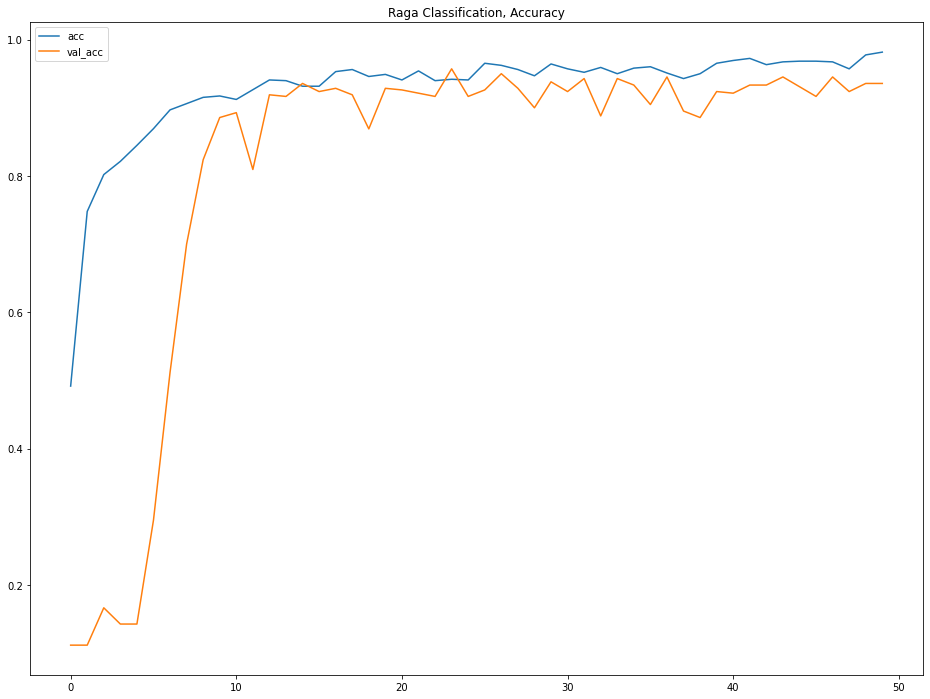

In [ ]:
pd.DataFrame(history.history)[['acc', 'val_acc']].plot(figsize = (16,12), 
                                                       title = "Raga Classification, Accuracy")

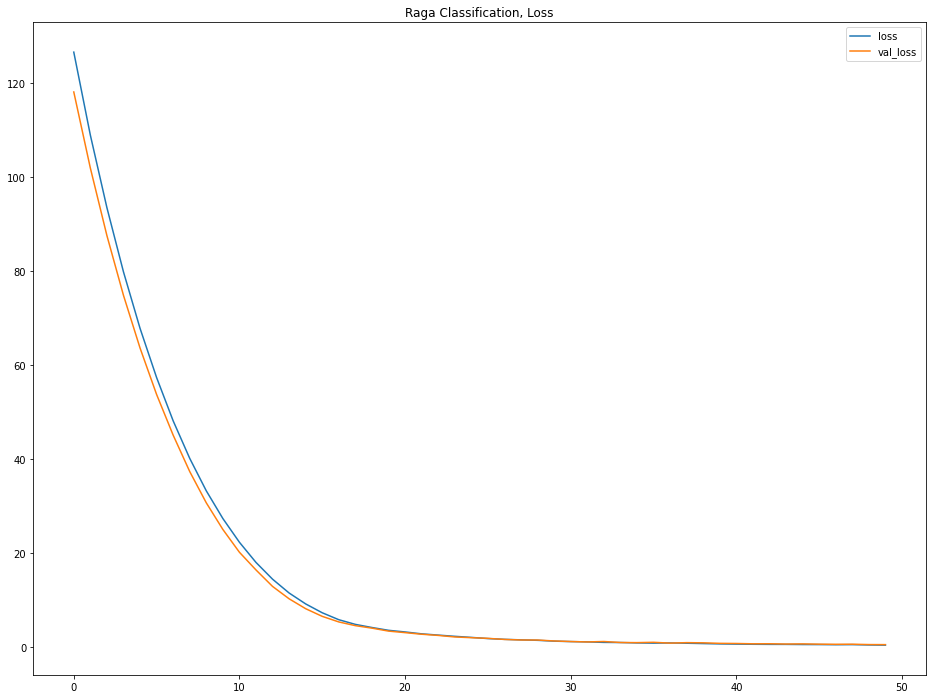

In [ ]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize = (16,12), title = "Raga Classification, Loss")

In [ ]:
model.save("/content/drive/My Drive/AIExplorations/carnatic_ragas_data/model.h5")

# Trying the model out

Below the model is being used to predict the class for a clip. We process the clip first, and then feed it to the `predict()` method in the model.

In [ ]:
model_loaded = tf.keras.models.load_model("/content/drive/My Drive/AIExplorations/carnatic_ragas_data/model.h5")

In [ ]:
model_loaded.compile(optimizer = 'adam', loss= 'sparse_categorical_crossentropy', metrics= ['acc'])
print(model_loaded.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 1, 37500, 200)     4200      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 375, 200)       0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 92, 100)        200100    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1, 92, 100)        400       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 1, 1, 100)         0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 1, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 128)           

We load the mean and standard deviation from the scaler object, so as to easily transform an individual entry. When we feed multiple entries into the scaler, this approach is not needed.

In [ ]:
mu, sig = scaler.mean_ , scaler.scale_

In [ ]:
def pre_process_file(filepath):
  sound = AudioSegment.from_file(filepath, sample_rate_Hz=12000, 
                                 sample_width = 1, 
                                 channels = 1, 
                                 format = 'mp3')
  sequence = np.array(sound.get_array_of_samples()[0:SNIPPETSIZE])
  sequence_scaled = (sequence - mu) / sig
  return sequence_scaled.reshape(1, 1, SNIPPETSIZE, 1)


# Visualizing the Audio File

In [ ]:
def visualize_audio(filepath):
  sound = AudioSegment.from_file(filepath, sample_rate_Hz = 12000,
                                 sample_width = 1,
                                 channels = 1,
                                 format = 'mp3')
  sequence = np.array(sound.get_array_of_samples()[0:SNIPPETSIZE])
  plt.figure(figsize = (24,6))
  plt.plot(sequence)
  plt.title("Sequence plotted from file")
  plt.show()

Here, we supply a test file, process it for feeding it into the model, and then run the predict function from the model. We can also run predict_class(), which is a method that predicts the specific class of the song. Using this and the raga dictionary, we can build a simple mapper to predict any given file.

In [ ]:
testfile = "/content/drive/My Drive/AIExplorations/carnatic_ragas_data/new_processed_data/thodi/thodi06821.mp3"

test_sequence = pre_process_file(testfile)

print(test_sequence)

[[[[ 0.03779321]
   [-0.01385818]
   [ 0.03870048]
   ...
   [ 0.96290611]
   [ 0.83204134]
   [ 0.91148988]]]]


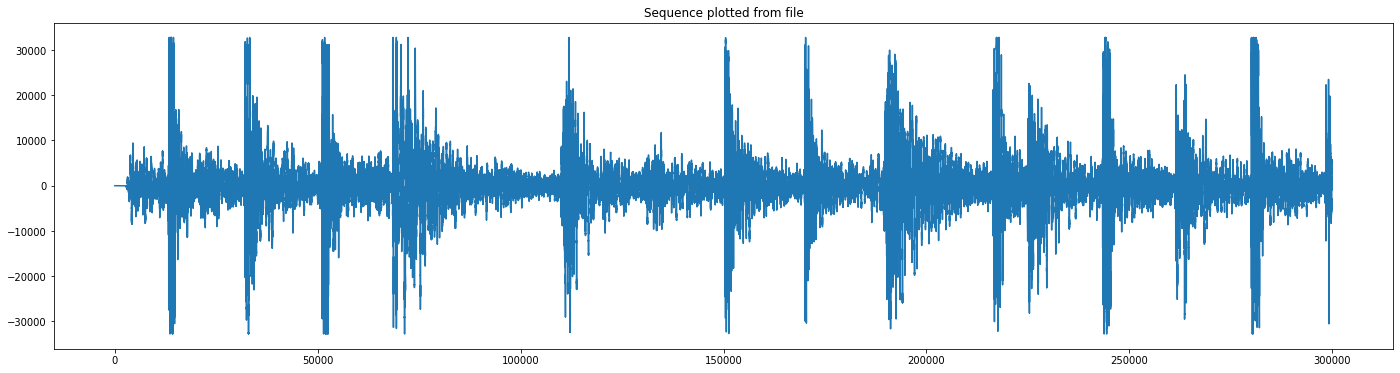

In [ ]:
visualize_audio(testfile)

In [ ]:
def identify_raga(file_name):
  '''
  Input: file name of track (5 second track processed from location on filesystem)
  Output: prediction of the raga with probability
  Usage: Model should be imported into the currently active kernel
  '''
  test_sequence = pre_process_file(file_name)
  pred = model_loaded.predict_classes(test_sequence)[0]
  pred_prob = model_loaded.predict(test_sequence)[0][pred]
  dict_raga = {value: key for key,value in raga_dict.items()}
  #print(dict_raga)
  print ("The raga is", dict_raga[pred], "with a probability of", pred_prob)

In [ ]:
identify_raga(testfile)

The raga is thodi with a probability of 0.98699385


# Studying the model's performance

We can construct typical model metrics and confusion matrices to understand the classification model's effectiveness overall on training and test sets.

In [ ]:
from sklearn.metrics import confusion_matrix

predictions_tr = model_loaded.predict_classes(train_x_sc.reshape(train_x_sc.shape[0], 1, train_x_sc.shape[1], 1))
predictions_ts = model_loaded.predict_classes(test_x_sc.reshape(test_x_sc.shape[0], 1, test_x_sc.shape[1], 1))

[[153   0   0   0   0   0   0]
 [  0 138   1   0   0   1   0]
 [  0   0 138   0   0   2   0]
 [  0   0   0 149   0   1   0]
 [  0   2   0   0 134   0   0]
 [  0   0   0   0   0 123   0]
 [  0   0   2   0   0   0 136]]


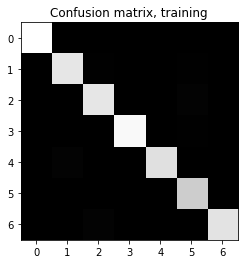

In [ ]:
# Training set confusion matrix
cfm_tr = confusion_matrix(train_y, predictions_tr)
plt.imshow(cfm_tr, cmap = 'gray');
plt.title("Confusion matrix, training");
print(cfm_tr)

[[47  0  0  0  0  0  0]
 [ 0 56  2  0  1  1  0]
 [ 0  0 59  0  0  0  1]
 [ 0  0  0 49  0  1  0]
 [ 0  3  5  0 55  1  0]
 [ 0  0  0  0  0 77  0]
 [ 0  0 10  0  1  1 50]]


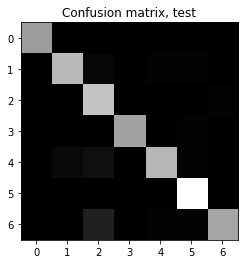

In [ ]:
# Test set confusion matrix

cfm_ts = confusion_matrix(test_y, predictions_ts)
plt.imshow(cfm_ts, cmap = 'gray')
plt.title("Confusion matrix, test")
print(cfm_ts)